# Step 2-2. Hyperparameter Tuning (Optional)
----

### Objective
1. Sagemaker에서 제공하는 하이퍼파라메터 튜닝 기능을 활용하여 최적 파라메터를 자동으로 도출합니다.

### Description
- Scikit-learn에서 기본으로 제공하지 않는 **Bayesian Optimization** 방식을 디폴트로 채택하였기 때문에, 사전 지식(prior knowledge)을 반영하여 불필요한 탐색 공간을 줄일 수 있습니다.
- Bayesian Optimization에 대한 자세한 내용은 아래 논문들을 참조하시기 바랍니다.
    - Shahriari, Bobak, et al. “Taking the human out of the loop: A review of bayesian optimization.” Proceedings of the IEEE 104.1 (2016): 148-175.
    - Brochu, Eric, Vlad M. Cora, and Nando De Freitas. “A tutorial on Bayesian optimization of expensive cost functions, with application to active user modeling and hierarchical reinforcement learning.” arXiv preprint arXiv:1012.2599 (2010).

In [1]:
import boto3
import os
import numpy as np
import pandas as pd

s3 = boto3.client('s3')
feature_dir_name = 'modeling-feature-190808'     
bucket = 'analytics-preprocessed-daekeun'    # s3 bucket name
dataset = 'homecredit'
prefix_target = os.path.join(dataset, feature_dir_name)

- `get_execution_role()`은 노트북 인스턴스를 생성할 때 만든 IAM 역할을 검색하여 리턴합니다.

In [2]:
from sagemaker import get_execution_role
role = get_execution_role()
region = boto3.Session().region_name
print(region)

us-west-2


In [3]:
import sagemaker
from sagemaker.predictor import csv_serializer
from sagemaker.amazon.amazon_estimator import get_image_uri

s3_trn_path = 's3://{}/{}/train.libsvm'.format(bucket, prefix_target)
s3_val_path = 's3://{}/{}/valid.libsvm'.format(bucket, prefix_target)
s3_trn_input = sagemaker.s3_input(s3_data=s3_trn_path, content_type='libsvm')
s3_val_input = sagemaker.s3_input(s3_data=s3_val_path, content_type='libsvm')

s3_out_path = 's3://{}/{}/output'.format(bucket, dataset)
print([s3_trn_path, s3_val_path, s3_out_path])

['s3://analytics-preprocessed-daekeun/homecredit/modeling-feature-190808/train.libsvm', 's3://analytics-preprocessed-daekeun/homecredit/modeling-feature-190808/valid.libsvm', 's3://analytics-preprocessed-daekeun/homecredit/output']


<br>

## 1. Set-up Hyperparameter search range
----
- 하이퍼파라메터 탐색 공간을 딕셔너리 형태로 정의합니다. 
- 딕셔너리의 key는 해당 알고리즘의 하이퍼파라메터명을 정의하고 value에서 search range를 지정합니다.
    - Search range는 하이퍼파라메터명에 따라 `ContinuousParameter`, `IntegerParameter`, `CategoricalParameter` 중 하나를 지정합니다.
    - 일부 하이퍼파라메터들은 등간격 파라메터보다 10의 거듭제곱을 선택해야 효율적으로 최적의 파라메터를 찾을 수 있습니다.
     (예: 0.1, 0.2, 0.3 vs. 1, 0.1, 0.01, ...)

In [4]:
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, CategoricalParameter, ContinuousParameter    

sess = sagemaker.Session()
container = get_image_uri(boto3.Session().region_name, 'xgboost', repo_version='latest')

xgb = sagemaker.estimator.Estimator(
    container,
    role,
    train_instance_count=1,
    train_instance_type='ml.m5.4xlarge',
    output_path=s3_out_path,
    base_job_name='HPO-xgb-homecredit',
    sagemaker_session=sess)

xgb.set_hyperparameters(    
    eval_metric='auc',
    scale_pos_weight=8,   
    max_depth=6,
    objective='binary:logistic',
    num_round=200
)

hyperparameter_ranges = {
    'eta': ContinuousParameter(0.01, 0.1),
    'alpha': ContinuousParameter(0.01, 10, scaling_type="Logarithmic"),
    'lambda': ContinuousParameter(0.01, 10, scaling_type="Logarithmic"),
    'gamma': IntegerParameter(0, 5),
    'min_child_weight': IntegerParameter(10, 30),
    'subsample': ContinuousParameter(0.5, 0.8),
    'colsample_bytree': ContinuousParameter(0.5, 0.8)
}  

In [5]:
objective_metric_name = 'validation:auc'
metric_definitions = [{'Name': 'validation:auc',
                       'Regex': 'validation:auc=([0-9\\.]+)'}]

tuner = HyperparameterTuner(
    estimator=xgb,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    objective_type='Maximize', # AUC needs to maximize
    max_jobs=150,
    max_parallel_jobs=5
)

<br>

## 2. Start Tuning Job
----
- `max_parallel_jobs=5` 설정에서 약 1.5시간 소요됩니다. 튜닝이 완료되면 대쉬보드(Amazon SageMaker > Training > Hyperparameter tuning jobs)나 아래 코드로 확인할 수 있습니다.
```python
status = boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']
assert status == 'Completed', "First must be completed, was {}".format(status)
```

In [6]:
tuner.fit({'train': s3_trn_input, 'validation': s3_val_input}) 

- Check of the hyperparameter tuning jobs status

In [8]:
status = boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']
assert status == 'Completed', "First must be completed, was {}".format(status)

<br>

## 3. Analyze Tuning Job results
----
- job_name을 매개변수로 받는 `sagemaker.HyperparameterTuningJobAnalytics()`함수를 호출하여 하이퍼파라메터 튜닝 결과를 pandas 데이터프레임으로 받아올 수 있습니다.
- 해당 결과를 matplotlib, seaborn, bokeh, plotly로도 확인할 수 있습니다.
- 좀 더 자세한 결과는 `step2-3-HPO_Analyze_TuningJob_Results.ipynb`를 참조하시면 됩니다. 이 노트북은 Sagemaker Example의 코드를 그대로 사용하였습니다.

In [9]:
status

'Completed'

In [10]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = sagemaker.HyperparameterTuningJobAnalytics(tuner.latest_tuning_job.job_name).dataframe()

In [11]:
df.sort_values(by='FinalObjectiveValue', ascending=False)

,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,alpha,colsample_bytree,eta,gamma,lambda,min_child_weight,subsample
78,0.782975,113.0,2019-08-15 09:34:29+00:00,xgboost-190815-0826-072-3e8914ec,Completed,2019-08-15 09:32:36+00:00,4.188911,0.505681,0.080522,4.0,9.761121,28.0,0.755967
77,0.782945,127.0,2019-08-15 09:34:54+00:00,xgboost-190815-0826-073-67bb8495,Completed,2019-08-15 09:32:47+00:00,3.648389,0.505681,0.080522,4.0,9.003442,28.0,0.755967
7,0.782918,124.0,2019-08-15 10:35:46+00:00,xgboost-190815-0826-143-a28a97a7,Completed,2019-08-15 10:33:42+00:00,9.962834,0.561217,0.086621,4.0,0.127095,19.0,0.797477
25,0.782863,112.0,2019-08-15 10:18:47+00:00,xgboost-190815-0826-125-e8a03cd2,Completed,2019-08-15 10:16:55+00:00,3.827777,0.500000,0.079515,2.0,4.423997,19.0,0.800000
83,0.782782,124.0,2019-08-15 09:30:14+00:00,xgboost-190815-0826-067-1cf83f6b,Completed,2019-08-15 09:28:10+00:00,0.120849,0.615508,0.076202,4.0,8.608764,30.0,0.800000
71,0.782756,116.0,2019-08-15 09:39:07+00:00,xgboost-190815-0826-079-f6a79524,Completed,2019-08-15 09:37:11+00:00,4.188911,0.505681,0.080522,4.0,10.000000,28.0,0.755967
64,0.782672,116.0,2019-08-15 09:47:33+00:00,xgboost-190815-0826-086-50a887b9,Completed,2019-08-15 09:45:37+00:00,6.642430,0.521602,0.071909,5.0,1.445263,26.0,0.795453
108,0.782640,122.0,2019-08-15 09:08:28+00:00,xgboost-190815-0826-042-75057f6c,Completed,2019-08-15 09:06:26+00:00,8.487950,0.562902,0.077317,5.0,8.284727,28.0,0.796378
22,0.782447,126.0,2019-08-15 10:22:33+00:00,xgboost-190815-0826-128-c33e5f1f,Completed,2019-08-15 10:20:27+00:00,3.597737,0.502914,0.080021,2.0,4.128737,19.0,0.797187
69,0.782428,112.0,2019-08-15 09:43:13+00:00,xgboost-190815-0826-081-b0dd6ca4,Completed,2019-08-15 09:41:21+00:00,3.909320,0.508681,0.081422,4.0,9.647362,28.0,0.752967


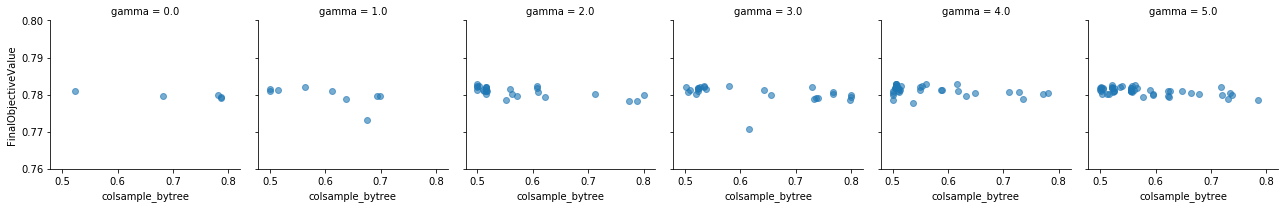

In [14]:
g = sns.FacetGrid(df, col="gamma", palette='viridis')
g = g.map(plt.scatter, "colsample_bytree", "FinalObjectiveValue", alpha=0.6)